In [158]:
import cv2
import os
import glob
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from skimage import exposure
from keras.utils import np_utils
from skimage import feature
import mahotas

In [159]:
dataAugment = False
if(dataAugment): from keras.preprocessing.image import ImageDataGenerator
    
augRatio = 2  #Data augmentation時，要產生幾倍數量的dataset
testimg = "dataset/train/Small-flowered Cranesbill/1f14ed265.png"
ratioVal = 0.2  #要從train dataset取出多少比例的資料作為validate dataset
reSize=(112,112)  #訓練前圖片要縮放的尺寸
bins = (30, 30, 30)
epochs = 50  #要跑幾個世代
batch_size = 32   #每批次提取多少數量的圖片進行訓練
trainDataset = "dataset/train"  #Train dataset的路徑
testDataset = "dataset/test"   #Test dataset的路徑
#Lable的對應, 每個Lable對應到一個數值
dict_labels = {"Black-grass": 0,"Charlock": 1, "Cleavers": 2, "Common Chickweed": 3, "Common wheat": 4, "Fat Hen": 5,
              "Loose Silky-bent": 6, "Maize": 7, "Scentless Mayweed": 8, "Shepherds Purse": 9, "Small-flowered Cranesbill": 10, 
              "Sugar beet": 11 }

#存放dataset及Label使用
orgimages = []
orgimagenames = []
images_1 = []
images_2 = []
labels = []
labels_hot = []
testImages_1 = []
testImages_2 = []
testImagesName = []

In [160]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='acc') else 'upper right'
    plt.legend(['train', 'validation'], loc=legendLoc)
    plt.show()

In [161]:
def load_image(folder):    
    global images_1, images_2,labels, labels_hot, dict_labels, orgimages, orgimagenames, bins
    
    for filename in os.listdir(folder):
        label = os.path.basename(folders)
        className = np.asarray( label )        
        if label is not None:
            labels.append(className)
            labels_hot.append(dict_labels[label])
            #np.append(labels, className , axis=0)
            #np.append(labels_hot, np.array(dict_labels[label]), axis=0)
            
        img = cv2.imread(os.path.join(folder,filename))
        orgimages.append(np.array(img))
        orgimagenames.append(filename)
        if img is not None:            
            img_extract1 = extractPlantsArea1(img)
            img_extract2 = extractPlantsArea2(img)
            
            images_1.append(np.array(img_extract1))
            images_2.append(np.array(img_extract2))            
            

In [162]:
def getMask(orgimg):
    img = cv2.cvtColor(orgimg, cv2.COLOR_BGR2HSV)
    lower_color = np.array([25, 40, 40]) 
    upper_color = np.array([100, 225, 225]) 
    plants = cv2.inRange(img, lower_color , upper_color)   
    
    clone = plants.copy()    
    _, cnts, _ = cv2.findContours(clone,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)          
    mask = np.zeros(orgimg.shape[:2], dtype="uint8")
    
    for c in cnts:
        cv2.drawContours(mask, [c], -1, 255, -1)
    
    return mask

def extractPlantsArea1(orgimg):
    global reSize
    orgimg = cv2.resize(orgimg,reSize,interpolation=cv2.INTER_CUBIC)
    mask = getMask(orgimg)
    image = cv2.bitwise_and(orgimg, orgimg, mask=mask)

    #image_blur = cv2.bilateralFilter(image,3,255,255) 
    #img = cv2.addWeighted(image, 1.5, image_blur, -0.5, 0)
    
    return image

def extractPlantsArea2(image):
    mask = getMask(image)
    image = cv2.bitwise_and(image, image, mask=mask)
    (means, stds) = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    colorStats = np.concatenate([means, stds]).flatten()
 
    # extract Haralick texture features
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
 
    # return a concatenated feature vector of color statistics and Haralick
    # texture features
    return np.hstack([colorStats, haralick])

def extractPlantsArea2_2(image):
    mask = getMask(image)
    image = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, 24, 8, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=range(0, 24 + 3),
        range=(0, 24 + 2))
 
    # normalize the histogram
    eps=1e-7
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    return hist

def extractPlantsArea2_1(image, bins=(30, 30, 30)):
    mask = getMask(image)
    image = cv2.bitwise_and(image, image, mask=mask)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hist = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
    
    hist = cv2.normalize(hist,hist).flatten()
    
    return hist

In [163]:
print("Load images from Train dataset")
for folders in glob.glob(trainDataset+"/*"):
    print("Load {} ...".format(folders))
    load_image(folders)
    
print("Load images from Test dataset")    
for filename in os.listdir(testDataset):
    img = cv2.imread(testDataset+"/"+filename)
    
    if img is not None:
        img_extract1 = extractPlantsArea1(img)
        img_extract2 = extractPlantsArea2(img)

        testImages_1.append(np.array(img_extract1))
        testImages_2.append(np.array(img_extract2))
        
        testImagesName.append(filename)

Load images from Train dataset
Load dataset/train/Common Chickweed ...
Load dataset/train/Scentless Mayweed ...
Load dataset/train/Maize ...
Load dataset/train/Charlock ...
Load dataset/train/Loose Silky-bent ...
Load dataset/train/Common wheat ...
Load dataset/train/Cleavers ...
Load dataset/train/Sugar beet ...
Load dataset/train/Small-flowered Cranesbill ...
Load dataset/train/Fat Hen ...
Load dataset/train/Shepherds Purse ...
Load dataset/train/Black-grass ...
Load images from Test dataset


In [164]:
images_1 = np.array(images_1) 
images_2 = np.array(images_2) 
labels_hot = np.array(labels_hot)
testImages_1 = np.array(testImages_1) 
testImages_2 = np.array(testImages_2) 
print("images_1.shape={} , images_2.shape={}, testImages_1.shape=={}, testImages_2.shape={}".format(images_1.shape, images_2.shape, testImages_1.shape, testImages_2.shape))


images_1.shape=(4750, 112, 112, 3) , images_2.shape=(4750, 19), testImages_1.shape==(794, 112, 112, 3), testImages_2.shape=(794, 19)


File:a9e3465f8.png, Label:Common Chickweed , ID:3, shape:(99, 99, 3)


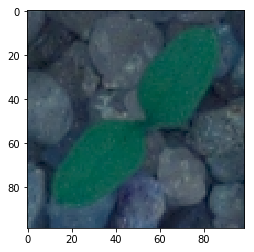

In [165]:
sampleID = 244
#print(images[3])
plt.imshow(orgimages[sampleID])
print("File:{}, Label:{} , ID:{}, shape:{}".format(orgimagenames[sampleID], labels[sampleID], labels_hot[sampleID], orgimages[sampleID].shape))

Label:Common Chickweed , ID:3, shape:(112, 112, 3)


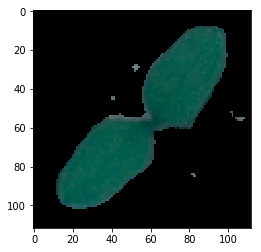

In [166]:

plt.imshow(images_1[sampleID])
print("Label:{} , ID:{}, shape:{}".format(labels[sampleID], labels_hot[sampleID], images_1[sampleID].shape))

In [167]:
if(dataAugment):
    (trainData_1, valiData_1, trainLabels_1, valiLabels_1) = train_test_split(images, labels_hot, test_size=ratioVal, random_state=42)
    (trainData_2, valiData_2, trainLabels_2, valiLabels_2) = train_test_split(images_2, labels_hot, test_size=ratioVal, random_state=42)

In [168]:
if(dataAugment):
    print("trainData records: {}".format(len(trainData_1)))
    print("trainData.shape={} trainLabels.shape={}".format(trainData_1.shape, trainLabels_1.shape))


    print("valiData records: {}".format(len(valiData_1)))
    print("valiData.shape={} valiLabels.shape={}".format(valiData_1.shape, valiLabels_1.shape))

In [169]:
if(dataAugment):
    trainLabels_hot = np_utils.to_categorical(labels_hot)
    valiLabels_hot = np_utils.to_categorical(valiLabels)
    print("Validate dataset:", valiLabels_hot.shape)
    
else:
    trainLabels_hot = np_utils.to_categorical(labels_hot)
    print("Train dataset: ", trainLabels_hot.shape)

Train dataset:  (4750, 12)


In [170]:
print(images_2.shape)

(4750, 19)


In [171]:

trainData_normalize_1 = images_1.astype('float32') / 255.0
trainData_normalize_2 = images_2.astype('float32') / 255.0

if(dataAugment):
    valiData_normalize = valiData.astype('float32') / 255.0
    
testImages_normalize_1 = testImages_1.astype('float32') / 255.0
testImages_normalize_2 = testImages_2.astype('float32') / 255.0


In [172]:
if(dataAugment):
    train_datagen = ImageDataGenerator(
        zoom_range = 0.15,
        shear_range=0.5,
        rotation_range = 60)
    
    valdi_datagen =  ImageDataGenerator(
        zoom_range = 0.15,
        shear_range=0.5,
        rotation_range = 60)
    
    train_generator = train_datagen.flow(trainData_normalize, trainLabels_hot, batch_size=batch_size)
    valdi_generator = valdi_datagen.flow(valiData_normalize, valiLabels_hot, batch_size=batch_size)    

# Models

In [173]:
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.callbacks import LearningRateScheduler
#from keras.layers import BatchNormalization


In [133]:
# Shared Input Layer
'''
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

# input layer
visible = Input(shape=(reSize[0], reSize[1], 3))
# first feature extractor
conv1 = Conv2D(64, kernel_size=7, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)
conv11 = Conv2D(64, kernel_size=5, activation='relu')(pool1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
pool11 = Dropout(0.25)(pool11)
flat1 = Flatten()(pool11)
# second feature extractor
conv2 = Conv2D(32, kernel_size=3, activation='relu')(visible)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.25)(pool2)
conv21 = Conv2D(32, kernel_size=3, activation='relu')(pool2)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
pool21 = Dropout(0.25)(pool21)
flat2 = Flatten()(pool21)
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
hidden1 = Dense(1024, activation='relu')(merge)
hidden1 = Dropout(0.4)(hidden1)
# prediction output
output = Dense(12, activation='sigmoid')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')
'''

"\nfrom keras.utils import plot_model\nfrom keras.models import Model\nfrom keras.layers import Input\nfrom keras.layers import Dense\nfrom keras.layers import Flatten\nfrom keras.layers.convolutional import Conv2D\nfrom keras.layers.pooling import MaxPooling2D\nfrom keras.layers.merge import concatenate\n\n# input layer\nvisible = Input(shape=(reSize[0], reSize[1], 3))\n# first feature extractor\nconv1 = Conv2D(64, kernel_size=7, activation='relu')(visible)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\npool1 = Dropout(0.25)(pool1)\nconv11 = Conv2D(64, kernel_size=5, activation='relu')(pool1)\npool11 = MaxPooling2D(pool_size=(2, 2))(conv11)\npool11 = Dropout(0.25)(pool11)\nflat1 = Flatten()(pool11)\n# second feature extractor\nconv2 = Conv2D(32, kernel_size=3, activation='relu')(visible)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\npool2 = Dropout(0.25)(pool2)\nconv21 = Conv2D(32, kernel_size=3, activation='relu')(pool2)\npool21 = MaxPooling2D(pool_size=(2, 2))(conv21)\npool21 = D

In [174]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

# first input model
visible1 = Input(shape=(reSize[0], reSize[1], 3))
conv11 = Conv2D(64, kernel_size=5, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
#pool11 = Dropout(0.25)(pool11)
conv12 = Conv2D(32, kernel_size=3, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
#pool12 = Dropout(0.25)(pool12)
flat1 = Flatten()(pool12)
# second input model
visible2 = Input(shape=(images_2.shape[1],))
hidden2_1 = Dense(1024, activation='relu')(visible2)
#hidden2_1 = Dropout(0.25)(hidden2_1)
#flat2 = Flatten()(visible2)
# merge input models
merge = concatenate([flat1, hidden2_1])
# interpretation model
hidden1 = Dense(1024, activation='relu')(merge)
hidden2 = Dense(512, activation='relu')(hidden1)
output = Dense(12, activation='sigmoid')(hidden2)
model = Model(inputs=[visible1, visible2], outputs=output)

# summarize layers
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 112, 112, 3)   0                                            
____________________________________________________________________________________________________
conv2d_17 (Conv2D)               (None, 108, 108, 64)  4864        input_17[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D)  (None, 54, 54, 64)    0           conv2d_17[0][0]                  
____________________________________________________________________________________________________
conv2d_18 (Conv2D)               (None, 52, 52, 32)    18464       max_pooling2d_17[0][0]           
___________________________________________________________________________________________

In [175]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]


In [176]:
steps_per_epoch=int((len(trainData_normalize_1)*augRatio)/batch_size)
#validation_steps = int((len(valiData_normalize_1)*augRatio)/batch_size)

print("batch_size={}".format(batch_size))
print("trainLabels_hot.shape={}".format(trainLabels_hot.shape))
print("steps_per_epoch={}".format(steps_per_epoch))

batch_size=32
trainLabels_hot.shape=(4750, 12)
steps_per_epoch=296


In [177]:
#from keras.optimizers import SGD
from keras import optimizers
#model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

sgd = optimizers.SGD(lr=1e-4, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#ADAM = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer=ADAM, metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])

if(dataAugment):
    train_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                    validation_data=valdi_generator, validation_steps=validation_steps, callbacks=callbacks_list)
    #train_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
    #                validation_data=valdi_generator, validation_steps=validation_steps)
    
else:    
    train_history = model.fit(x=[trainData_normalize_1,trainData_normalize_2], y=trainLabels_hot, validation_split=ratioVal, 
                              epochs=epochs, batch_size=batch_size, verbose=1, callbacks=callbacks_list)


Train on 3800 samples, validate on 950 samples
Epoch 1/50
3800/3800 [==============================] - 86s - loss: 0.2431 - acc: 0.9193 - val_loss: 0.5817 - val_acc: 0.8941
Epoch 2/50
3800/3800 [==============================] - 86s - loss: 0.1712 - acc: 0.9334 - val_loss: 0.6526 - val_acc: 0.8825
Epoch 3/50
3800/3800 [==============================] - 86s - loss: 0.1399 - acc: 0.9441 - val_loss: 0.7567 - val_acc: 0.8697
Epoch 4/50
3800/3800 [==============================] - 86s - loss: 0.1147 - acc: 0.9555 - val_loss: 0.7550 - val_acc: 0.8745
Epoch 5/50
3800/3800 [==============================] - 86s - loss: 0.0830 - acc: 0.9692 - val_loss: 0.7174 - val_acc: 0.8599
Epoch 6/50
3800/3800 [==============================] - 86s - loss: 0.0671 - acc: 0.9752 - val_loss: 0.8342 - val_acc: 0.8645
Epoch 7/50
3800/3800 [==============================] - 86s - loss: 0.0467 - acc: 0.9831 - val_loss: 0.7554 - val_acc: 0.8619
Epoch 8/50
3800/3800 [==============================] - 86s - loss: 0.0

KeyboardInterrupt: 

In [ ]:
show_train_history(train_history, 'acc', 'val_acc')
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
Y_pred = model.predict(testImages_normalize_1)

In [ ]:
import pandas as pd 
inv_dict_labels = {v: k for k, v in dict_labels.items()}

results = np.argmax(Y_pred,axis = 1)
testFiles = []
testPredict = []
i=0
for filename in os.listdir(testDataset):
    #print("{}) {}".format(i, results[i]))
    testFiles.append(filename)
    testPredict.append(inv_dict_labels[results[i]])
    print("{},{}".format(filename, inv_dict_labels[results[i]]))
    i += 1

submission = pd.DataFrame({
        "file": testFiles,
        "species": testPredict
    })
submission.to_csv('Plant-submission.csv', index=False)